# STREET NETWORKS + ACCESSIBILITY

Today we are going to use the street network to compute measures of accessibility. To do this, we will lean on "Dijkstra's algorithm", which is a method for finding the shortest path between two points in a graph. In this case, the graph is the street network, and the points are intersections of streets.

## Dijkstra's Algorithm Steps:

* **Step 1**: Initialize all nodes with infinite distance; set starting node distance to 0
* **Step 2**: Select the unvisited node with minimum distance
* **Step 3**: Mark the selected node as visited
* **Step 4**: Update distances to all adjacent unvisited nodes
* **Step 5**: Repeat steps 2-4 until destination is reached or all nodes are visited

[**N.B.** When you are working with very large graphs, you might try the A* algorithm, which is a more efficient version of Dijkstra's algorithm. It limits the search space by establishing a maximum "detour" beyond the direct path, focusing only on promising routes. So you can imagine, if you are trying to get from Berlin to Rome, your street network might be all of Europe but we could throw out the possibility of going through Athens or something.]

In [113]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

let's start by getting the data, something you are already familiar with

In [114]:
# grab the street network for our area of interest
G = ox.graph.graph_from_place('Borough of Havering, London, UK', network_type='walk')

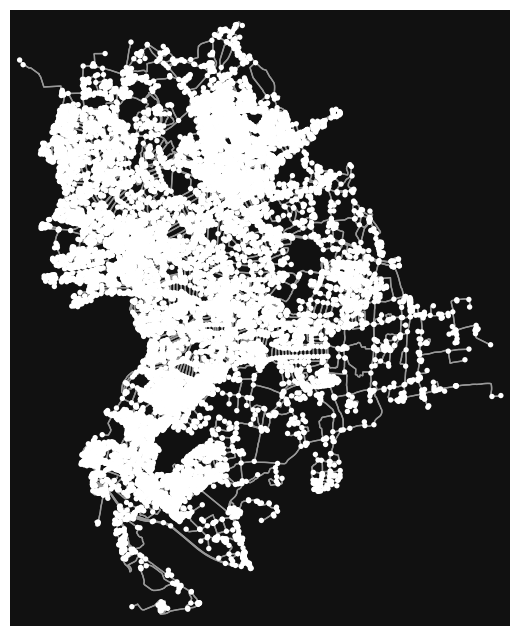

In [115]:
# remember how to plot the graph
fig, ax = ox.plot_graph(G)

In [116]:
# get the administrative boundary of the area
area = ox.geocode_to_gdf('Borough of Havering, London, UK')

<Axes: >

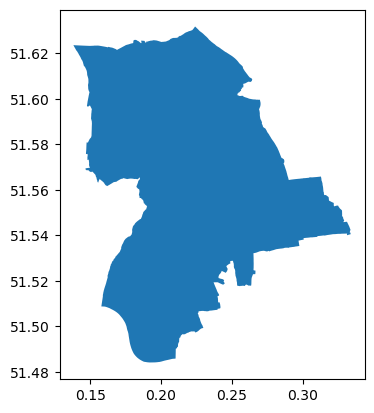

In [117]:
area.plot()

In [118]:
area.explore()

for this and the assessment, we are going to use data on supermarkets from geolytix

In [120]:
retail = pd.read_csv("./geolytix_retailpoints_v34_202412.csv")
retail = gpd.GeoDataFrame(retail, geometry=gpd.points_from_xy(retail['long_wgs'], retail['lat_wgs']), crs="EPSG:4326")
retail = retail[retail['geometry'].within(area.loc[0, 'geometry'])]
retail.head()

id                              retailer                 fascia  \
8880  1010001769                     Marks and Spencer   Marks and Spencer BP   
8881  1010000785                                  Asda        Asda Superstore   
8882  1010008077                The Co-operative Group  The Co-operative Food   
8883  1010011531  Chelmsford Star Co-operative Society  The Co-operative Food   
8884  1010014460             The Southern Co-operative  The Co-operative Food   

                              store_name                  add_one  \
8880                   M&S Hornchurch BP   Southend Arterial Road   
8881             Asda Romford Superstore         Dolphin Approach   
8882                   Co-op Harold Wood          15 Station Road   
8883                    Co-op Mungo Park      150 Mungo Park Road   
8884  Co-op Hornchurch - Hornchurch Road  176-178 Hornchurch Road   

              add_two    town        suburb  postcode  long_wgs    lat_wgs  \
8880              NaN  London  Emerson Park  RM11 3UJ  0.240395  51.579830   
8881  Mercury Gardens  London       Romford   RM1 3EE  0.185560  51.579473   
8882      Harold Wood  London   Harold Wood   RM3 0BP  0.233400  51.593581   
8883              NaN  London      Elm Park  RM13 7PP  0.192236  51.540285   
8884              NaN  London    Heath Park  RM11 1QL  0.200812  51.564993   

              bng_e          bng_n      pqi   open_date  \
8880  555332.371570  189152.128284  Rooftop         NaN   
8881  551534.511561  188997.348277  Rooftop         NaN   
8882  554801.026269  190666.388789  Rooftop         NaN   
8883  552127.681563  184653.568262  Rooftop         NaN   
8884  552639.622492  187418.963916  Rooftop  20179999.0   

                    size_band          county                  geometry  
8880      < 3,013 ft2 (280m2)  Greater London   POINT (0.2404 51.57983)  
8881  30,138 ft2 > (2,800 m2)  Greater London  POINT (0.18556 51.57947)  
8882      < 3,013 ft2 (280m2)  Greater London   POINT (0.2334 51.59358)  
8883      < 3,013 ft2 (280m2)  Greater London  POINT (0.19224 51.54028)  
8884      < 3,013 ft2 (280m2)  Greater London  POINT (0.20081 51.56499)

In [121]:
# how many grocery locations are there?
retail.shape

(56, 18)

In [122]:
# for some of the plotting, it would be nice to have an integer value for square footage
import re
def extract_square_meter(x):
    # natch the square meter value, even if there is a range
    match = re.search(r'\((\d{1,3}(?:,\d{3})*)\s*(?:<\s*\d{1,3}(?:,\d{3})*)?\s*m2\)', x)
    if match:
        # extract the first value in the range, or the single value
        square_meter_str = match.group(1).replace(",", "")
        return int(square_meter_str)
    return None

retail['square_meters'] = retail['size_band'].apply(lambda x: extract_square_meter(x))
retail.head()


id                              retailer                 fascia  \
8880  1010001769                     Marks and Spencer   Marks and Spencer BP   
8881  1010000785                                  Asda        Asda Superstore   
8882  1010008077                The Co-operative Group  The Co-operative Food   
8883  1010011531  Chelmsford Star Co-operative Society  The Co-operative Food   
8884  1010014460             The Southern Co-operative  The Co-operative Food   

                              store_name                  add_one  \
8880                   M&S Hornchurch BP   Southend Arterial Road   
8881             Asda Romford Superstore         Dolphin Approach   
8882                   Co-op Harold Wood          15 Station Road   
8883                    Co-op Mungo Park      150 Mungo Park Road   
8884  Co-op Hornchurch - Hornchurch Road  176-178 Hornchurch Road   

              add_two    town        suburb  postcode  long_wgs    lat_wgs  \
8880              NaN  London  Emerson Park  RM11 3UJ  0.240395  51.579830   
8881  Mercury Gardens  London       Romford   RM1 3EE  0.185560  51.579473   
8882      Harold Wood  London   Harold Wood   RM3 0BP  0.233400  51.593581   
8883              NaN  London      Elm Park  RM13 7PP  0.192236  51.540285   
8884              NaN  London    Heath Park  RM11 1QL  0.200812  51.564993   

              bng_e          bng_n      pqi   open_date  \
8880  555332.371570  189152.128284  Rooftop         NaN   
8881  551534.511561  188997.348277  Rooftop         NaN   
8882  554801.026269  190666.388789  Rooftop         NaN   
8883  552127.681563  184653.568262  Rooftop         NaN   
8884  552639.622492  187418.963916  Rooftop  20179999.0   

                    size_band          county                  geometry  \
8880      < 3,013 ft2 (280m2)  Greater London   POINT (0.2404 51.57983)   
8881  30,138 ft2 > (2,800 m2)  Greater London  POINT (0.18556 51.57947)   
8882      < 3,013 ft2 (280m2)  Greater London   POINT (0.2334 51.59358)   
8883      < 3,013 ft2 (280m2)  Greater London  POINT (0.19224 51.54028)   
8884      < 3,013 ft2 (280m2)  Greater London  POINT (0.20081 51.56499)   

      square_meters  
8880            280  
8881           2800  
8882            280  
8883            280  
8884            280

In [123]:
nodes, edges = ox.graph_to_gdfs(G)

Text(0.5, 1.0, 'Retail locations in Havering, London')

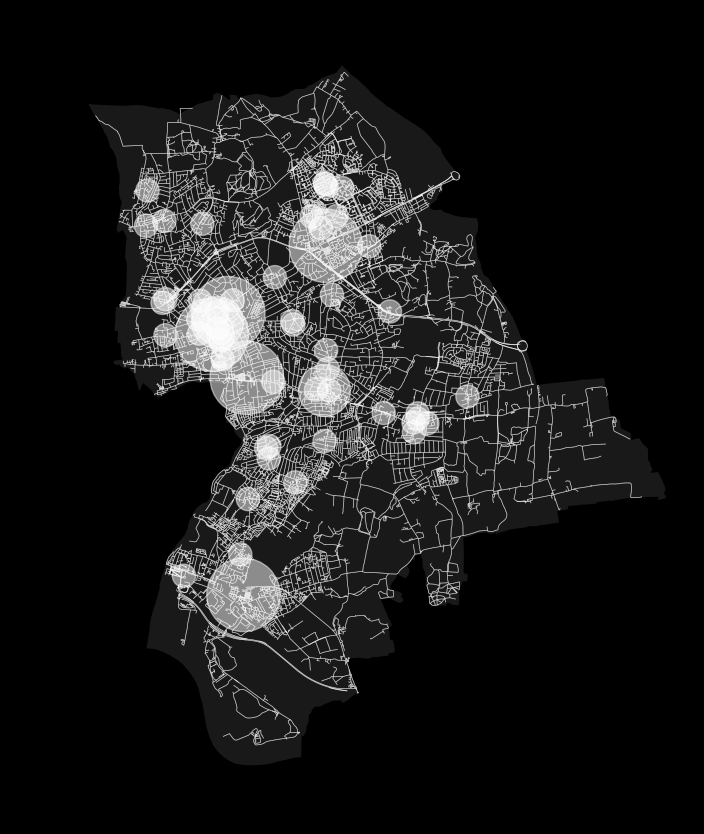

In [124]:

fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
area.plot(ax=ax, facecolor='w', alpha=0.1)
edges.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
retail.plot(color='w', ax=ax, markersize='square_meters', alpha=0.5)
ax.set_facecolor('k')
ax.set_title('Retail locations in Havering, London')

In [125]:
# what are the biggest stores
retail = retail.sort_values('square_meters', ascending=False)
retail.head()

id    retailer           fascia  \
8897   1010006288       Tesco      Tesco Extra   
8881   1010000785        Asda  Asda Superstore   
8910   1010003189  Sainsburys       Sainsburys   
18264  1010006287       Tesco      Tesco Extra   
8896   1010006290       Tesco      Tesco Extra   

                               store_name              add_one  \
8897                  Tesco Rainham Extra          Bridge Road   
8881              Asda Romford Superstore     Dolphin Approach   
8910                   Sainsburys Romford        1 The Brewery   
18264                 Tesco Romford Extra  300 Hornchurch Road   
8896   Tesco Romford Gallows Corner Extra        Bryant Avenue   

               add_two    town       suburb  postcode  long_wgs    lat_wgs  \
8897           Rainham  London      Rainham  RM13 9YZ  0.190737  51.520074   
8881   Mercury Gardens  London      Romford   RM1 3EE  0.185560  51.579473   
8910               NaN  London      Romford   RM1 1AU  0.179965  51.574915   
18264       Hornchurch  London   Heath Park  RM11 1PY  0.191840  51.565854   
8896           Romford  London  Harold Wood   RM3 0LL  0.218663  51.593686   

               bng_e          bng_n      pqi  open_date  \
8897   552091.001563  182402.998253  Rooftop        NaN   
8881   551534.511561  188997.348277  Rooftop        NaN   
8910   551162.001560  188478.998274  Rooftop        NaN   
18264  552015.001562  187495.998272  Rooftop        NaN   
8896   553780.001567  190646.998287  Rooftop        NaN   

                     size_band          county                  geometry  \
8897   30,138 ft2 > (2,800 m2)  Greater London  POINT (0.19074 51.52007)   
8881   30,138 ft2 > (2,800 m2)  Greater London  POINT (0.18556 51.57947)   
8910   30,138 ft2 > (2,800 m2)  Greater London  POINT (0.17997 51.57492)   
18264  30,138 ft2 > (2,800 m2)  Greater London  POINT (0.19184 51.56585)   
8896   30,138 ft2 > (2,800 m2)  Greater London  POINT (0.21866 51.59369)   

       square_meters  
8897            2800  
8881            2800  
8910            2800  
18264           2800  
8896            2800

In [126]:
# get the nearest network node to each point
retail['nodes'] = ox.nearest_nodes(G, retail['long_wgs'], retail['lat_wgs'])

In [127]:
retail['nodes'].to_numpy()

array([ 3126695258,    33472352,  2905549031,  4525271306,  1723271155,
        7097574945,    31073549, 11227619384,   245794863, 11909545221,
          31497656,    30865750,  5385551038,  5865912846,  7261100452,
        6322924734,  8628074642,  6332783669,    25894895,  2184904585,
        1567651769,  2142099759,    31387232,  8209435887,  8817642959,
        1127943270,   245015254, 10749201507,  6758859170,  3232129350,
          27340030,   747087848,  8205579182,  4472253157,  5380508003,
          31388110,  8091496508,    30991535,   245035059,  6769246246,
        4520240128,  6322924734,   747087748,  1266089657, 11132894624,
        3565590107,    45403833,    32567383,   245037871,  1612627338,
        2962708960,  2733299480, 11599007720,  3787358413,  6970755181,
        7265453259])

a voronoi diagram assigns points to a set of seed or generator points according to proximity

In [131]:
# get the shortest paths from all the nodes to all the entraces nodes
%time lines = nx.multi_source_dijkstra_path(G, set(retail['nodes'].to_numpy()), weight='length')
# voronoi cells creates a voronoi using the network rather than euclidean distance
%time cells = nx.voronoi_cells(G, set(retail['nodes'].to_numpy()), weight='length')

CPU times: user 80.2 ms, sys: 2.22 ms, total: 82.4 ms
Wall time: 81.2 ms
CPU times: user 63.7 ms, sys: 174 μs, total: 63.9 ms
Wall time: 64 ms


In [133]:
cells = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
merged = pd.concat(cells).merge(nodes, left_on='child', right_on='osmid', how='left')

In [134]:
import colorcet as cc

Text(0.5, 1.0, 'Grocery Catchments')

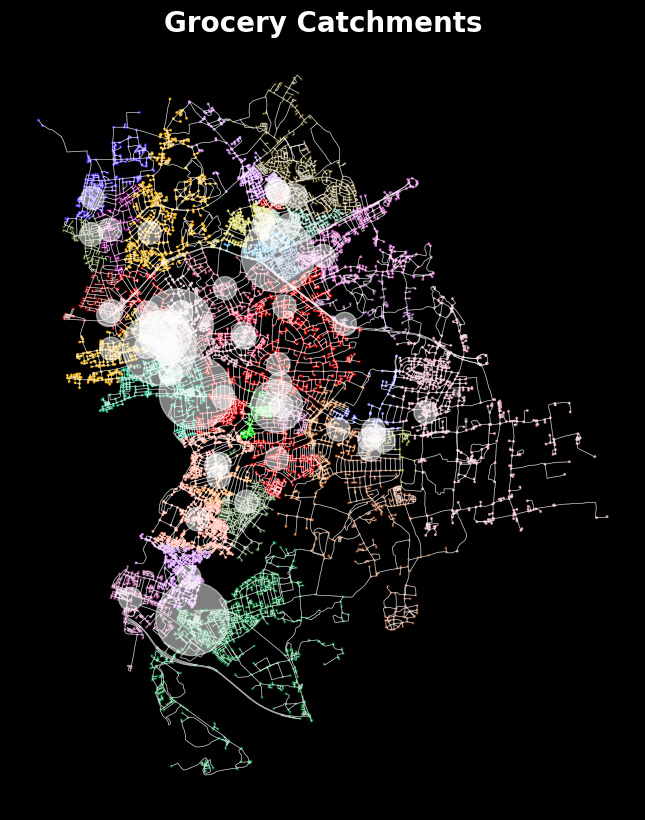

In [135]:
# plot the edges in black
fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
edges.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)

# convert the merge cell dataframe to a geodataframe and plot it
gpd.GeoDataFrame(merged, 
                 geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                 crs=4326).plot('parent', markersize=1, cmap=cc.cm.glasbey_dark, ax=ax)

# plot the stores in light grey to highlight them
retail.plot(color='w', ax=ax, markersize='square_meters', alpha=0.5)

# clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# add a title
ax.set_title('Grocery Catchments', fontsize=20, fontweight='bold', color='w')

we have now assigned each interaction to its nearest grocery store

In [ ]:
# let's check the distances to shops from all nodes
%time lengths = nx.multi_source_dijkstra_path_length(G, set(retail['nodes'].to_numpy()), weight="length")

CPU times: user 63.5 ms, sys: 2.51 ms, total: 66 ms
Wall time: 65 ms


In [138]:
# make a data frame of the lengths
lengths = pd.DataFrame({'osmid':lengths.keys(), 'distance': lengths.values()})
# there seem to be some outliers, let's remove them
lengths = lengths[lengths['distance'] < 2500]

In [139]:
# what is the average length
int(lengths['distance'].mean())

795

In [142]:
merged

parent        child          y         x  street_count highway  \
0      4520240128    245782552  51.564651  0.165581             3     NaN   
1      4520240128   6270599195  51.571672  0.183293             3     NaN   
2      4520240128   6270599196  51.571591  0.183323             1     NaN   
3      4520240128    245782556  51.565481  0.163816             3     NaN   
4      4520240128    245782561  51.565705  0.167131             3     NaN   
...           ...          ...        ...       ...           ...     ...   
16336    27340030  11909607389  51.574110  0.217869             3     NaN   
16337    27340030  11909607391  51.574021  0.217835             3     NaN   
16338    27340030  11909607399  51.574149  0.217883             3     NaN   
16339    27340030    248472045  51.569435  0.230646             1     NaN   
16340    27340030    248469998  51.568797  0.241222             1     NaN   

      railway  ref                  geometry  
0         NaN  NaN  POINT (0.16558 51.56465)  
1         NaN  NaN  POINT (0.18329 51.57167)  
2         NaN  NaN  POINT (0.18332 51.57159)  
3         NaN  NaN  POINT (0.16382 51.56548)  
4         NaN  NaN  POINT (0.16713 51.56571)  
...       ...  ...                       ...  
16336     NaN  NaN  POINT (0.21787 51.57411)  
16337     NaN  NaN  POINT (0.21784 51.57402)  
16338     NaN  NaN  POINT (0.21788 51.57415)  
16339     NaN  NaN  POINT (0.23065 51.56944)  
16340     NaN  NaN   POINT (0.24122 51.5688)  

[16341 rows x 9 columns]

Text(0.5, 1.0, 'Grocery Distances')

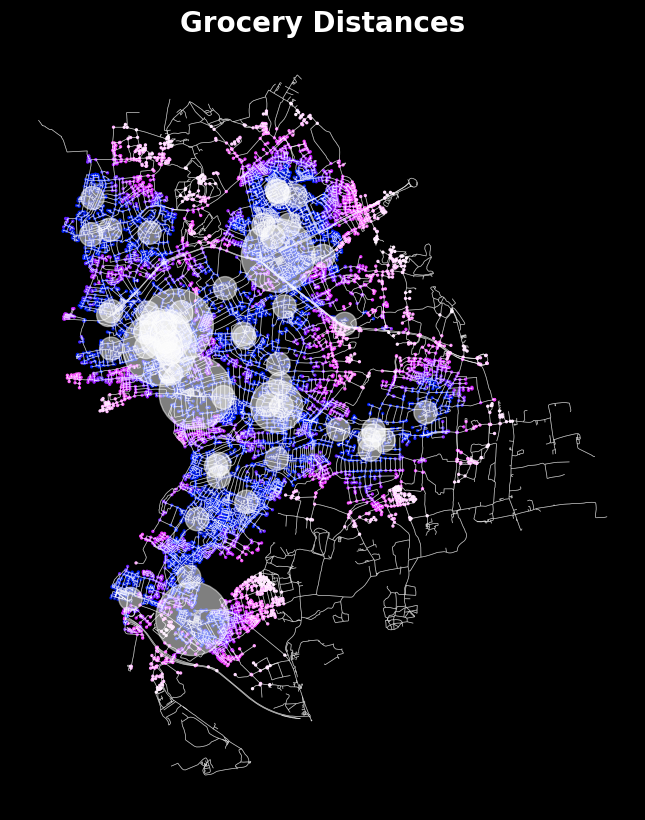

In [141]:
# same as before but with distance as the column of interest
fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
edges.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
gpd.GeoDataFrame(merged, 
                 geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                 crs=4326).merge(lengths, 
                                 left_on='child', 
                                 right_on='osmid',
                                 how='left').plot('distance', markersize=2, cmap=cc.cm.bmw, ax=ax)

# plot the stores in light grey to highlight them
retail.plot(color='w', ax=ax, markersize='square_meters', alpha=0.5)

# clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# add a title
ax.set_title('Grocery Distances', fontsize=20, fontweight='bold', color='w')

**Important:** For the practical you will need to be able to create a matrix that contains the distance between all origins and all destinations. What we have done so far assigns each node to its nearest grocery store. You will need to create a matrix that contains the distance between all nodes. This is a bit more complex, but we will guide you through it.

[If you are using a square matix, which we are not, you can use nx.all_pairs_dijkstra_path_length, but this takes a lot computational power and time.]

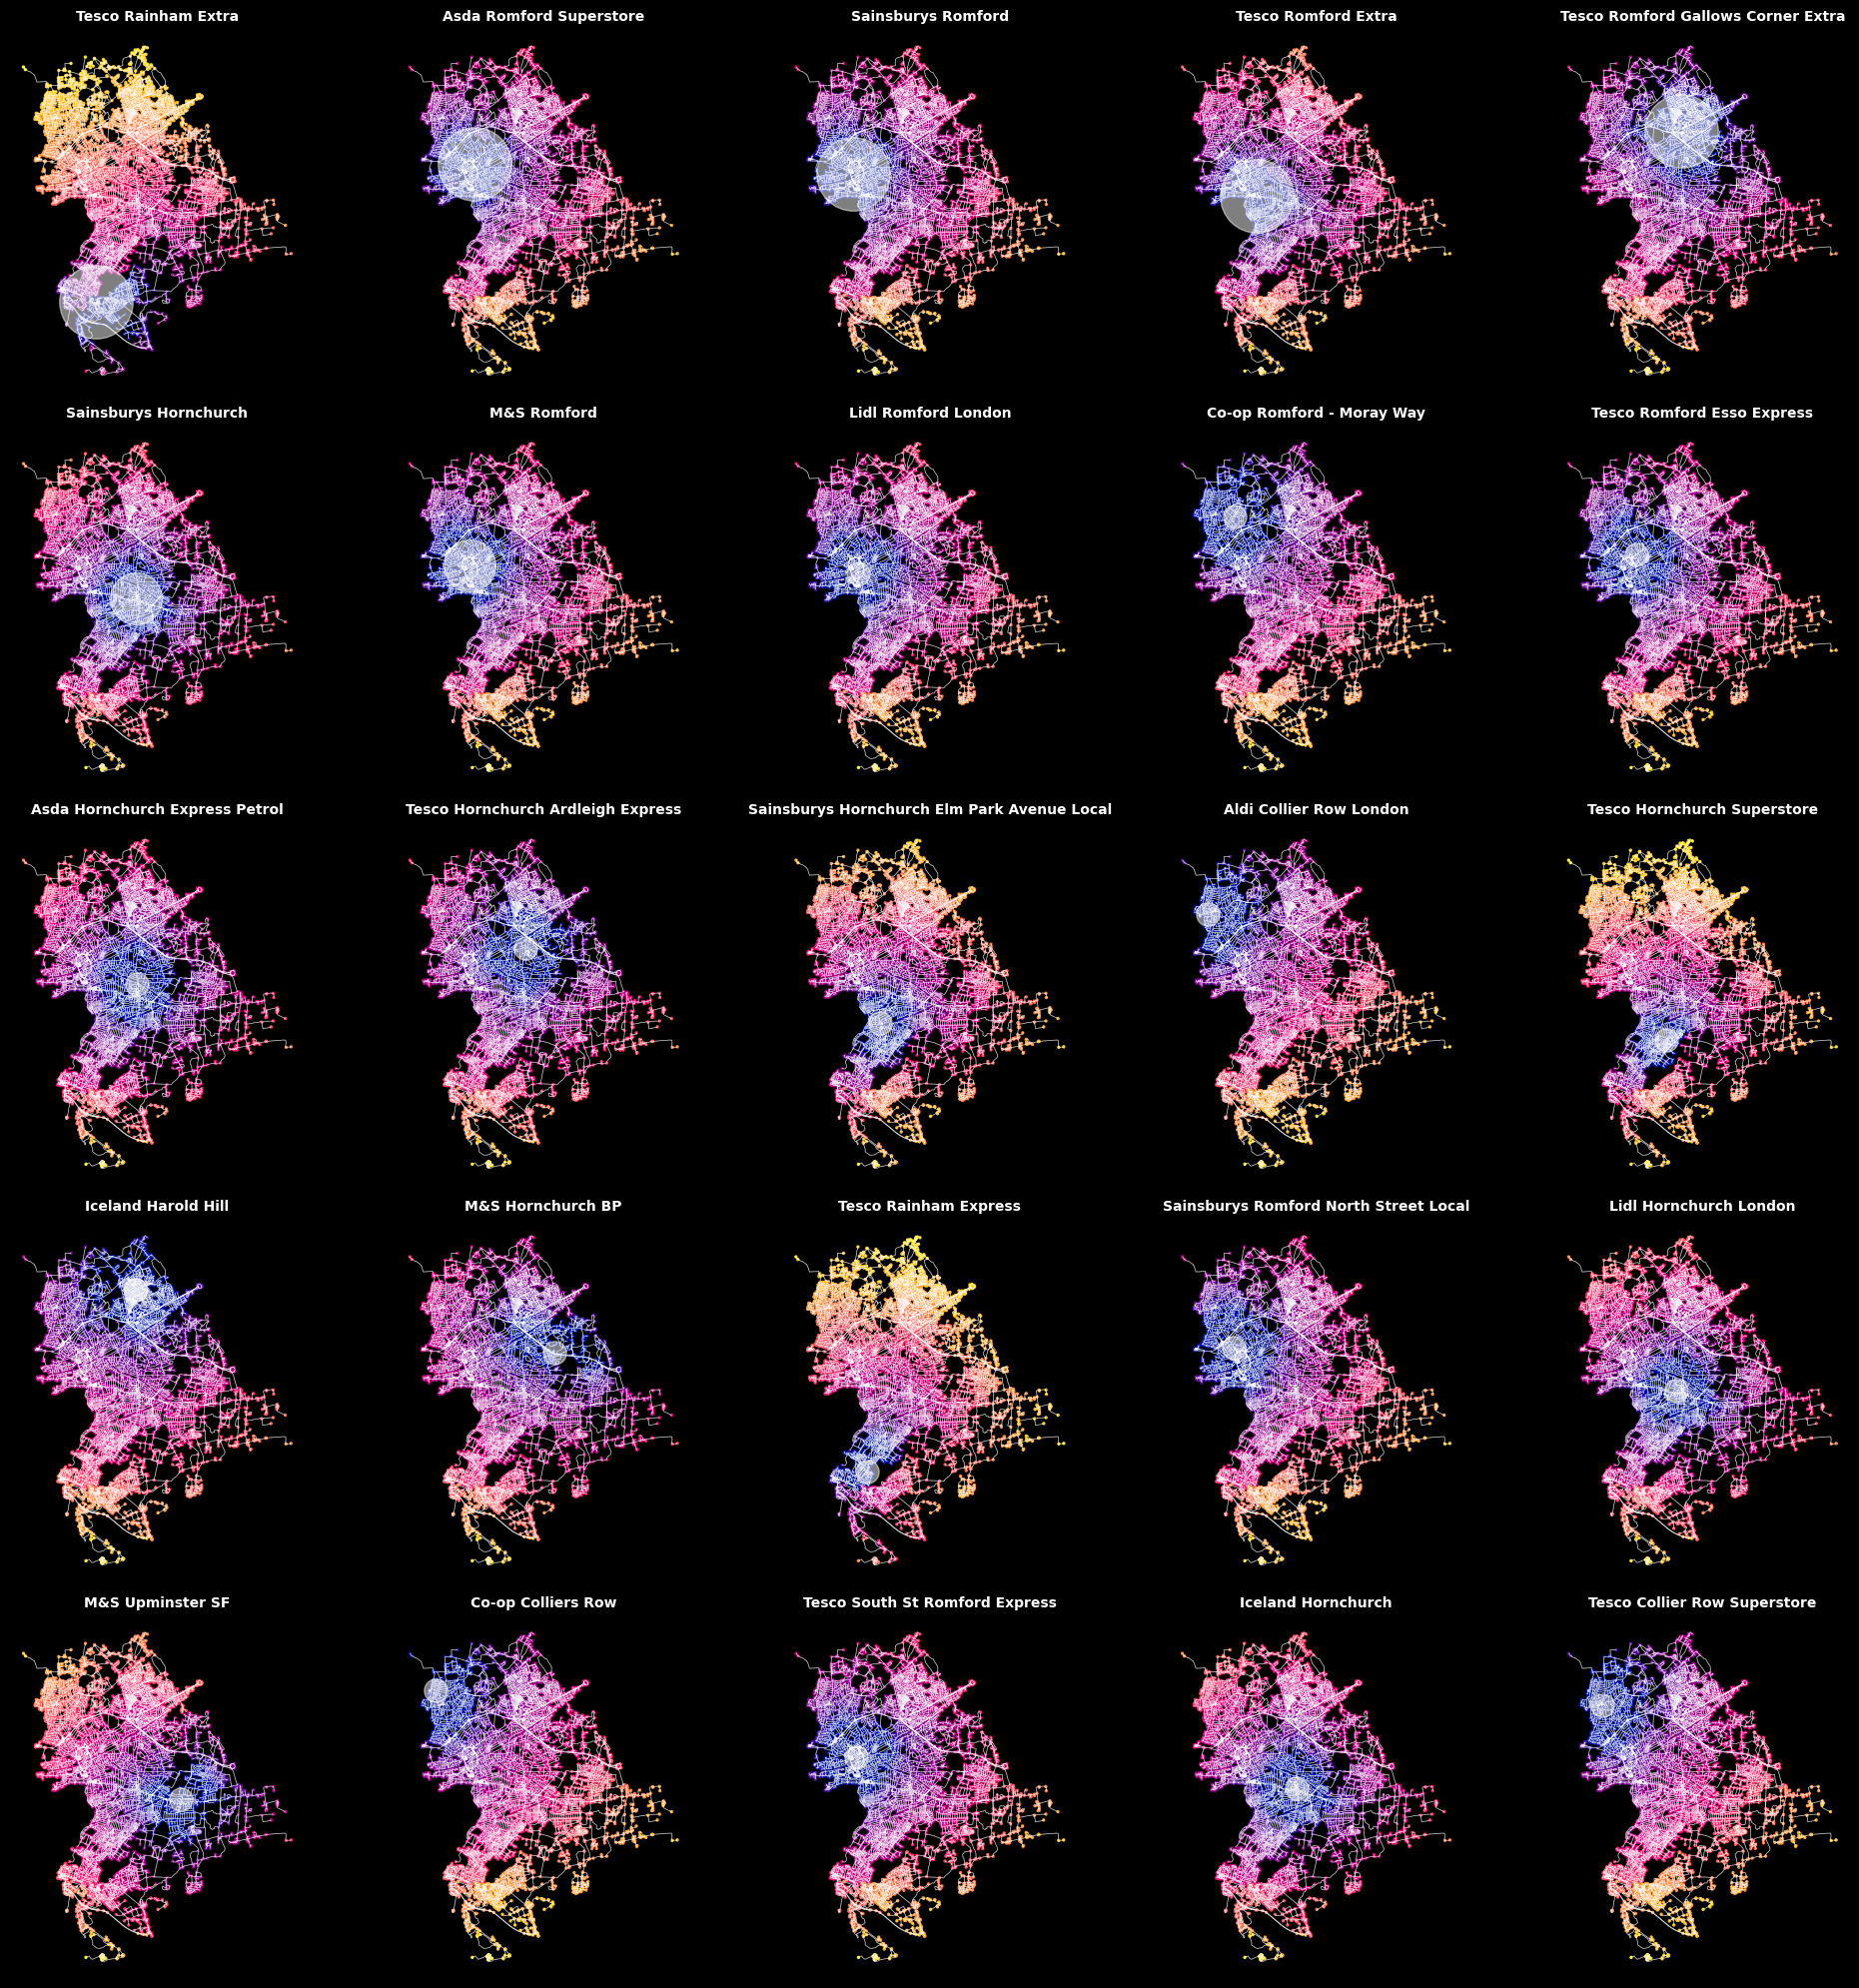

CPU times: user 4min 45s, sys: 4.93 s, total: 4min 50s
Wall time: 4min 50s


In [143]:
%%time
distances = {}

# we are only going to plot the top 25
retail = retail.reset_index(drop=True)
subset = retail.head(25)
fig, axs = plt.subplots(5, 5, figsize=(20, 20), facecolor='k')
axs = axs.ravel() 

# for each supermarket, let's get the distance to all nodes, and plot them all
for i, row in retail.iterrows():
    n = row['nodes']
    d = nx.single_source_dijkstra_path_length(G, n, weight='length')
    d = pd.DataFrame({'osmid': d.keys(), 'distance': d.values()})
    distances[n] = d

    if i < 25:
        
        edges.plot(color='w', ax=axs[i], linewidth=0.5, alpha=0.5)
        gpd.GeoDataFrame(merged, 
                        geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                        crs=4326).merge(d, 
                                        left_on='child', 
                                        right_on='osmid',
                                        how='left').plot('distance', markersize=2, cmap=cc.cm.bmy, ax=axs[i])
        
        retail[retail['nodes']==n].plot(color='w', ax=axs[i], markersize='square_meters', alpha=0.5)
        axs[i].set_axis_off()
        axs[i].set_facecolor('k')
        axs[i].set_title(row['store_name'], fontsize=10, fontweight='bold', color='w')

plt.tight_layout()
plt.show()

In [146]:
D = pd.concat(distances).reset_index().drop('level_1', axis=1).rename(columns={'level_0': 'node'}).pivot(index='node', columns='osmid', values='distance')
D

osmid         132503        132507        132510        132517       \
node                                                                  
25894895      9491.139623   9667.420383  10651.196975  13208.210230   
27340030      8697.084715   8873.365475   9857.142067  12414.155322   
30865750     10061.115970  10237.396731  11221.173323  13778.186577   
30991535      9598.823445   9095.209873   9198.778964  11755.792219   
31073549      8852.327553   9028.608313  10012.384906  12569.398160   
31387232      8713.453800   8889.734561   9873.511153  12430.524408   
31388110      7771.566788   7947.847549   8931.624141  11488.637396   
31497656      8285.768415   8462.049175   9445.825767  12002.839022   
32567383     13472.344926  13648.625687  14632.402279  17189.415534   
33472352      9204.359854   9380.640614  10364.417207  12921.430461   
45403833      6905.018199   7081.298960   8065.075552  10622.088806   
245015254     9802.695817   9978.976577  10962.753170  13519.766424   
245035059     8916.518473   9092.799234  10076.575826  12633.589080   
245037871     9145.078388   9321.359148  10305.135741  12862.148995   
245794863    11594.405257  11770.686018  12754.462610  15311.475864   
747087748    10171.207612  10347.488372  11331.264965  13888.278219   
747087848    10113.872728  10290.153489  11273.930081  13830.943336   
1127943270    9257.489493   9433.770254  10417.546846  12974.560101   
1266089657   10614.601932  10790.882693  11774.659285  14331.672540   
1567651769    9613.748780   9188.842833   9292.411924  11849.425178   
1612627338    8565.736746   8742.017507   9725.794099  12282.807354   
1723271155   11522.923641  11699.204402  12682.980994  15239.994249   
2142099759   12810.432980  12986.713740  13970.490333  16527.503587   
2184904585    7668.767881   7845.048642   8828.825234  11385.838489   
2733299480    9512.103530   9033.130456   9136.699547  11693.712801   
2905549031    8871.465036   9047.745796  10031.522389  12588.535643   
2962708960    9872.699035   9357.918400   9461.487491  12018.500746   
3126695258    2900.216356   1905.683370   2009.252462   4566.265716   
3232129350    9606.471754   8791.604496   8895.173587  11452.186841   
3565590107    5452.246626   5628.527387   6612.303979   9169.317234   
3787358413   12412.103311  12588.384071  13572.160664  16129.173918   
4472253157   12310.914223  12487.194984  13470.971576  16027.984831   
4520240128    8023.700921   8199.981682   9183.758274  11740.771529   
4525271306    7484.844791   7661.125552   8644.902144  11201.915399   
5380508003    4323.355412   4499.636173   5483.412765   8040.426020   
5385551038    5733.174747   5909.455507   6893.232100   9450.245354   
5865912846   12161.862169  12338.142929  13321.919522  15878.932776   
6322924734   13578.556334  13754.837095  14738.613687  17295.626942   
6332783669    3321.284650   3497.565410   4481.342003   7038.355257   
6758859170    9317.198840   9493.479600  10477.256192  13034.269447   
6769246246   11152.283890  10655.449459  10759.018550  13316.031805   
6970755181   13520.144634  13696.425394  14680.201987  17237.215241   
7097574945    7787.656467   7963.937227   8947.713820  11504.727074   
7261100452    5484.519284   5660.800044   6644.576637   9201.589891   
7265453259    5940.615905   6116.896665   7100.673258   9657.686512   
8091496508    8667.963316   8818.606629   8922.175720  11479.188975   
8205579182    1613.905972   1790.186732   2773.963325   5330.976579   
8209435887    7938.456637   8114.737398   9098.513990  11655.527245   
8628074642   11809.351291  11985.632051  12969.408644  15526.421898   
8817642959   11859.055271  12035.336031  13019.112624  15576.125878   
10749201507   9409.793491   9586.074252  10569.850844  13126.864099   
11132894624  12301.361068  12477.641829  13461.418421  16018.431676   
11227619384   8460.479188   8636.759948   9620.536541  12177.549795   
11599007720  12702.214025  12878.494786  13862.271378  16419.284633   
11909545221   9527.21005

In [ ]:
print(len(retail))
print(len(nodes))

56
16341


In [148]:
oa = gpd.read_file("./loac/loac_oa.gpkg")
oa = oa.to_crs(4326)
oa = oa[oa['geometry'].centroid.within(area.loc[0, 'geometry'])]
oa.head()

/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_17721/501938290.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  oa = oa[oa['geometry'].centroid.within(area.loc[0, 'geometry'])]


OA21CD   G SG                                           geometry
10547  E00011202  F2  F  MULTIPOLYGON (((0.15152 51.56798, 0.15081 51.5...
10548  E00011203  C2  C  MULTIPOLYGON (((0.17613 51.56765, 0.17642 51.5...
10549  E00011204  F1  F  MULTIPOLYGON (((0.16159 51.57077, 0.16296 51.5...
10550  E00011205  C2  C  MULTIPOLYGON (((0.18131 51.56826, 0.18306 51.5...
10551  E00011206  F1  F  MULTIPOLYGON (((0.18696 51.56557, 0.18624 51.5...

<Axes: >

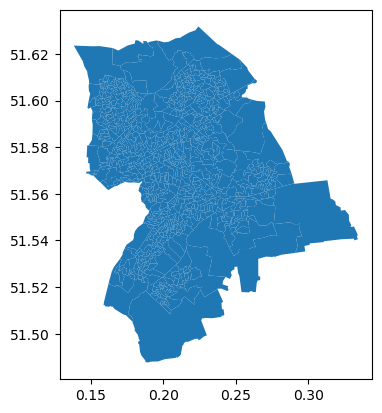

In [149]:
oa.plot()

In [150]:
oa.shape

(775, 4)

In [151]:
n2o = nodes.sjoin(oa, how='left').reset_index()
n2o = n2o[['osmid', 'OA21CD']]

In [93]:
# let's take this bit by bit
D_long = pd.concat(distances).reset_index().drop('level_1', axis=1).rename(columns={'level_0': 'node'})
D_join = D_long.merge(n2o, left_on='osmid', right_on='osmid', how='left')
D_wide = D_join.groupby(['node', 'OA21CD'], as_index=False).mean().pivot(index='OA21CD', columns='node', values='distance')
D_wide.head()

node       25894895     27340030     30865750     30991535     31073549     \
OA21CD                                                                       
E00011202  3185.113642  5228.732454  5469.650383  7389.067002  2938.266627   
E00011203  2081.062916  3861.305216  4214.212857  5467.791428  1695.872344   
E00011204  2752.148868  4850.018675  5090.936603  7010.353223  2510.495729   
E00011205  1848.878098  3596.238220  3921.883115  5335.724104  1450.474797   
E00011206  2089.151873  3234.101899  3729.324375  4785.439036  1500.174442   

node       31387232     31388110     31497656     32567383     33472352     \
OA21CD                                                                       
E00011202  2808.997633  3741.886248  5234.546284  7886.706497  3299.903687   
E00011203  1566.603351  1820.610674  3509.920053  6999.619661  2057.509405   
E00011204  2419.405262  3363.172469  4855.832504  7453.741723  2875.688627   
E00011205  1314.802631  1688.543350  3377.852729  6767.434843  1805.708685   
E00011206  1361.300690  1138.258282  2827.567661  6733.215063  1852.206743   

node       ...  8091496508   8205579182   8209435887   8628074642   \
OA21CD     ...                                                       
E00011202  ...  6465.635766  8744.779258  5125.720950  7122.294636   
E00011203  ...  4544.360191  6816.521591  3204.445376  5866.857110   
E00011204  ...  6086.921986  8366.065478  4747.007171  6743.580856   
E00011205  ...  4412.292868  6693.041388  3072.378052  5574.527368   
E00011206  ...  3862.007799  6145.588190  2522.092984  5381.968628   

node       8817642959   10749201507  11132894624  11227619384  11599007720  \
OA21CD                                                                       
E00011202  5093.868831  4303.526744  7206.334934  2571.478479  7718.490600   
E00011203  4448.978564  3009.217644  5952.430306  1316.659515  6464.585972   
E00011204  4660.904057  3924.812965  6773.370160  2192.764700  7285.525826   
E00011205  4216.793746  2703.666378  5662.022966  1053.791928  6174.178632   
E00011206  4457.067521  2436.044401  5562.231205  1108.326077  6074.386871   

node       11909545221  
OA21CD                  
E00011202  3599.908105  
E00011203  2357.513823  
E00011204  3171.226098  
E00011205  2125.329005  
E00011206  2175.056939  

[5 rows x 55 columns]

In [153]:
oa[~oa['OA21CD'].isin(D_wide.index)].explore()

In [154]:
oa['lon'] = oa['geometry'].centroid.x
oa['lat'] = oa['geometry'].centroid.y

/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_17721/3808644412.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  oa['lon'] = oa['geometry'].centroid.x
/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_17721/3808644412.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  oa['lat'] = oa['geometry'].centroid.y


In [155]:
oa['nodes'] = ox.nearest_nodes(G, oa['lon'], oa['lat'])

In [156]:
oa_sm = nx.multi_source_dijkstra_path_length(G, set(oa['nodes'].to_numpy()), weight='length')
oa_sm = pd.DataFrame({'osmid':oa_sm.keys(), 'distance': oa_sm.values()})
oa_sm = oa_sm[oa_sm['osmid'].isin(retail['nodes'].to_numpy())]
oa_sm

osmid     distance
1273    2905549031    32.775752
1452    3787358413    38.592111
1907    7261100452    52.769853
2079    3232129350    57.553783
2250    1127943270    61.717129
2689    1612627338    72.637427
3259      32567383    85.510406
3745    4472253157    95.155983
4282   11227619384   105.332333
4342     245015254   106.449551
4634    5385551038   112.275160
4830      27340030   116.170948
4986    8205579182   119.085408
5125   11599007720   121.944645
5182      30991535   122.899760
5414    6970755181   127.285112
5996    2142099759   138.334514
6334    7265453259   145.370795
6487    3565590107   148.765249
6508   11132894624   149.173459
6920    4525271306   157.501181
7303      30865750   165.166307
7471      31497656   168.619558
7540    6769246246   170.265504
7851     245794863   177.265844
8087      25894895   183.016990
8134    2733299480   183.972177
8332      31387232   188.154139
8351      31388110   188.560767
8698    1567651769   196.114550
8876    5380508003   200.371046
8989    2184904585   203.081468
9122     245035059   206.551533
9394   11909545221   213.821143
9418    8209435887   214.370959
9424    1723271155   214.562791
9474      45403833   215.812981
9711   10749201507   222.559144
9934    7097574945   228.414530
10158     31073549   234.526959
10316   5865912846   239.436353
10356    245037871   240.220711
11448   2962708960   275.592351
11988   6758859170   295.960387
12013   8091496508   297.205181
12014   8817642959   297.218320
12122   6322924734   301.629727
12128   1266089657   301.798015
12407    747087848   314.258926
12705   6332783669   327.762296
13100   3126695258   350.004101
13346     33472352   368.346866
13382    747087748   371.593809
13736   4520240128   403.153226
15527   8628074642  1175.007177

now we'll get into something else: access to transit

In [157]:
tube = ox.features.features_from_place('Borough of Havering, London, UK', tags={'railway': True})
tube = tube[~tube['name'].isna()]

<Axes: >

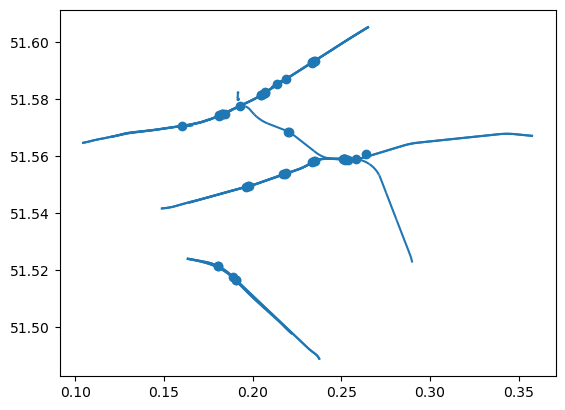

In [158]:
tube.plot()

let's simulate what happens when we remove a Tube stop from the street network. How much does that inconvenience people?

In [159]:
# let's check on the data
tube = tube[(tube['geometry'].type=='Point') & (tube['railway']=='stop') & (~tube['name'].isna())]
tube = tube[['name', 'operator', 'subway', 'geometry']]
tube.head(20)

name              operator subway  \
element id                                                                 
node    21596803                 Hornchurch  Transport for London    yes   
        21607411                 Gidea Park                   NaN    NaN   
        27512037    Emerson Park Platform 1                   NaN    NaN   
        606167840                  Elm Park  Transport for London    yes   
        1341527159                  Romford                   NaN    NaN   
        1514296645                Upminster                   NaN    NaN   
        1516415669                  Rainham                   NaN    NaN   
        1528614957         Upminster Bridge  Transport for London    yes   
        1611925649              Harold Wood                   NaN    NaN   
        1611925654              Harold Wood                   NaN    NaN   
        1611935124              Harold Wood                   NaN    NaN   
        1612592270                  Romford                   NaN    NaN   
        1612592304               Gidea Park                   NaN    NaN   
        1612598214                  Romford                   NaN    NaN   
        1612627337               Gidea Park                   NaN    NaN   
        1612627371                  Romford                   NaN    NaN   
        1612627412               Gidea Park                   NaN    NaN   
        1735759944               Hornchurch  Transport for London    yes   
        3052027780                 Elm Park  Transport for London    yes   
        3061312271         Upminster Bridge  Transport for London    yes   

                                    geometry  
element id                                    
node    21596803     POINT (0.2188 51.55404)  
        21607411    POINT (0.20487 51.58145)  
        27512037    POINT (0.22045 51.56855)  
        606167840   POINT (0.19636 51.54933)  
        1341527159  POINT (0.18423 51.57498)  
        1514296645  POINT (0.25184 51.55917)  
        1516415669  POINT (0.19064 51.51673)  
        1528614957  POINT (0.23546 51.55852)  
        1611925649  POINT (0.23366 51.59288)  
        1611925654  POINT (0.23349 51.59299)  
        1611935124  POINT (0.23498 51.59345)  
        1612592270  POINT (0.18265 51.57482)  
        1612592304  POINT (0.20705 51.58244)  
        1612598214  POINT (0.18134 51.57423)  
        1612627337  POINT (0.20499 51.58137)  
        1612627371   POINT (0.18315 51.5748)  
        1612627412  POINT (0.20717 51.58234)  
        1735759944  POINT (0.21721 51.55367)  
        3052027780  POINT (0.19824 51.54977)  
        3061312271  POINT (0.23372 51.55789)

some of these are entrances to the same stop, so let's get the average  coordinates

In [160]:
# remove Platform 1 from the name
tube['name'] = tube['name'].apply(lambda x: x.replace("Platform 1", "").strip())

In [162]:
# get the x,y from the geometries
tube['x'] = tube['geometry'].apply(lambda x: x.x)
tube['y'] = tube['geometry'].apply(lambda x: x.y)

In [163]:
# compute the average x,y per stop name
tube = tube.groupby('name', as_index=False).agg({'x':'mean', 'y':'mean'})
# reconstruct the gdf
tube = gpd.GeoDataFrame(tube, geometry=gpd.points_from_xy(tube['x'], tube['y']), crs=4326)

In [164]:
# how many distinct tube stops are there
tube.shape

(9, 4)

Text(0.5, 1.0, 'Tube locations in Havering, London')

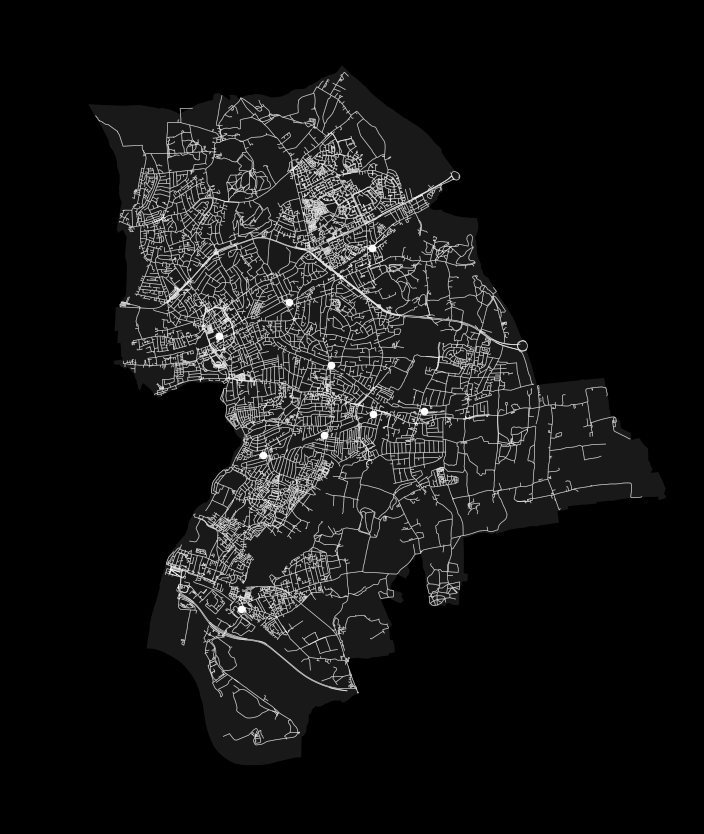

In [165]:

fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
area.plot(ax=ax, facecolor='w', alpha=0.1)
edges.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
tube.plot(color='w', ax=ax, markersize=20)
ax.set_facecolor('k')
ax.set_title('Tube locations in Havering, London')

In [166]:
tube.explore()

# Bonus

let's say Upminster closes for repairs, people will need to get to Emerson Park for Overground and Upminster Bridge for Tube. A few weeks ago, we used the shortest path function to get the distance between a few buildings in the Square Mile. Let's do the same thing, but now let's figure out how far the paths are from the old station to the new stations that will replace it. Remember, we want to get the nearest nodes and then we want to get the shortests paths. 

**Imagine we remove Upminster, now we need the shortest paths to the 2 new stations...**

+ plot the shortest paths between the old station and the new stations
+ get the distance values

[Hint: check out nx.shortest_path_length]

In [37]:
# shortest path on the network from Upminster to Emerson Park
o = ox.nearest_nodes(G, tube[tube['name']=='Upminster'].iloc[0]['x'], tube[tube['name']=='Upminster'].iloc[0]['y'])
d = ox.nearest_nodes(G, tube[tube['name']=='Emerson Park'].iloc[0]['x'], tube[tube['name']=='Emerson Park'].iloc[0]['y'])
# get the shortest path
path = nx.shortest_path(G, o, d, weight='length')

Upminster to Emerson Park | Distance: 3354.799652018803


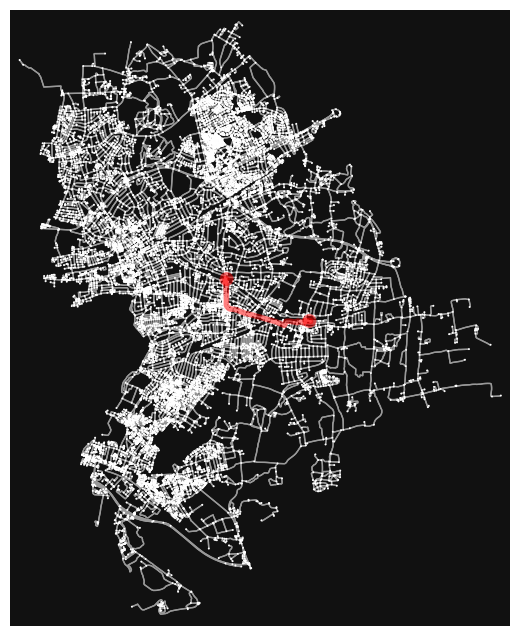

In [38]:
print(f"Upminster to Emerson Park | Distance: {nx.shortest_path_length(G, o, d, weight='length')}")
fig, ax = ox.plot_graph_route(G, path, node_size=2)

In [39]:
# shortest path on the network from Upminster to Emerson Park
o = ox.nearest_nodes(G, tube[tube['name']=='Upminster'].iloc[0]['x'], tube[tube['name']=='Upminster'].iloc[0]['y'])
d = ox.nearest_nodes(G, tube[tube['name']=='Upminster Bridge'].iloc[0]['x'], tube[tube['name']=='Upminster Bridge'].iloc[0]['y'])
# get the shortest path
path = nx.shortest_path(G, o, d, weight='length')

Upminster to Emerson Park | Distance: 1473.416995839201


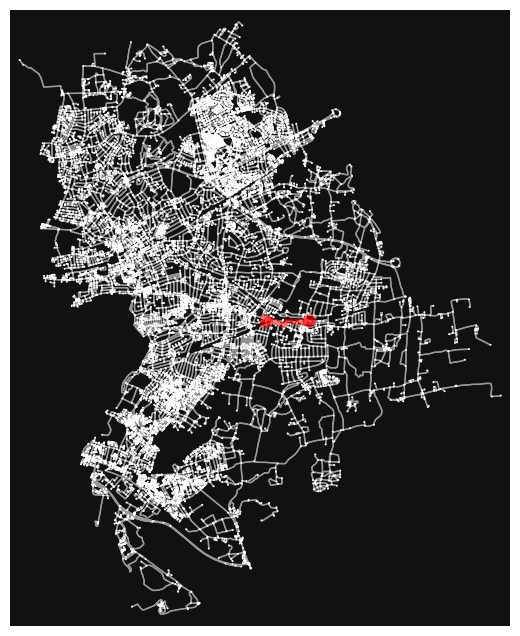

In [40]:
print(f"Upminster to Emerson Park | Distance: {nx.shortest_path_length(G, o, d, weight='length')}")
fig, ax = ox.plot_graph_route(G, path, node_size=2)